In [10]:
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
import matplotlib
import sys
from scipy import signal
%matplotlib inline

data_dir = './plotting_data'

def SetPlotRC():
    '''
    For ICML, NIPS etc. camera ready requirement
    '''
    plt.rc('pdf',fonttype = 42)
    plt.rc('ps',fonttype = 42)
    
SetPlotRC()

colors = ['seagreen', 'cornflowerblue',  'orange', 'gray', 'plum', 'lightcoral', 'dodgerblue']

In [91]:
!python tensorboard_extract.py --data_dir ../results --output_dir ./plotting_data --tag vanilla --expID 0001 0005
!python tensorboard_extract.py --data_dir ../results --output_dir ./plotting_data --tag att --expID 0002 0004

start extracting experiment 0001 from ../results/EXP_0001
2021-06-18 14:42:55.502188: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
experiment 0001 extraction saved to ./plotting_data/0001_vanilla.npy 
start extracting experiment 0005 from ../results/EXP_0005
experiment 0005 extraction saved to ./plotting_data/0005_vanilla.npy 
start extracting experiment 0002 from ../results/EXP_0002
2021-06-18 14:46:11.445906: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
tensorboard_extract.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.mean(np.array(data), axis=0)
Traceback (most recent call last):
  File "tensorboard_extrac

In [92]:
ls ./plotting_data

0001_vanilla.npy  0002_att.npy  0004_att.npy  0005_vanilla.npy


./plotting_data/0002_att.npy
./plotting_data/0001_vanilla.npy
./plotting_data/0004_att.npy
./plotting_data/0005_vanilla.npy


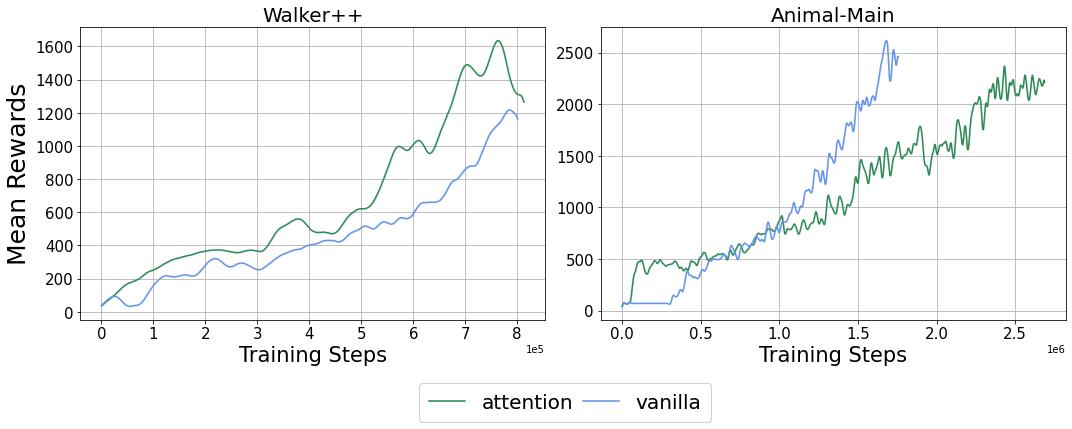

In [95]:
# smoothing param
win = signal.hann(18) #10, 50
# main exp figure
fig = plt.figure(figsize=(15, 6))
# keys -> titles for each subplot; value -> [(expID for curve1), (expID for curve2), ...]
all_id = {'Walker++ (10 kinds)': [range(3001, 3005), range(3005, 3009), range(3013, 3017), range(3009, 3013), range(4601, 4605)],
          'Humanoid++ (6 kinds)': [range(5121, 5125), range(5125, 5129), range(5129, 5133), range(5133, 5137), range(5157, 5161)],
          'Cheetah++ (12 kinds)': [range(3049, 3053), range(3053, 3057), range(3061, 3065), range(3057, 3061), range(4613, 4617)],
          'Walker-Hopper++ (12 kinds)': [range(3065, 3069), range(3069, 3073), range(3077, 3081), range(3073, 3077), range(4617, 4621)],
          'Walker-Hopper-Humanoid++ (18 kinds)': [range(5137, 5141), range(5141, 5145), range(5145, 5149), range(5149, 5153), range(5165, 5168)]
         }

all_id = {'Walker++': [['0002_att'],['0001_vanilla']],
         'Animal-Main': [['0004_att'],['0005_vanilla']],
         }

# loop over each subplot
i = 1
for title in all_id.keys():
    all_runs_id = all_id[title]
    ax = plt.subplot(1, 2, i)
    # labels for each curve
    labels = ['attention','vanilla']
    # loop over each curve
    for j in range(len(all_runs_id)):
        runs_id = all_runs_id[j]
        # get data from runs with different seeds 
        curve_data = []
        for run in runs_id:
            print(os.path.join(data_dir, '{}.npy'.format(run)))
            run_data = np.load(os.path.join(data_dir, '{}.npy'.format(run)))
            curve_data.append(run_data)
        # trim to the lowest len
        min_len = min([run_data.shape[-1] for run_data in curve_data])
        curve_data = np.array([run_data[:, :min_len] for run_data in curve_data]) # [runs #, (steps, rewards), min_len]
        steps = curve_data[:, 0, :] # [runs #, min_len]
        rewards = curve_data[:, 1, :] # [runs #, min_len]
        # take average and std across all runs
        steps_mean = np.mean(steps, axis=0).astype(np.int)
        rewards_mean = np.mean(rewards, axis=0)
        rewards_std = rewards.std(axis=0) / np.sqrt(rewards.shape[0])
        # assuming the first curve (bothway) has been trained for the least amount of time
        if j == 0:
            # record first curve's timestep to trim other curves
            min_steps = steps_mean[-1]
        else:
            # for other curves, find nearest step value to min_steps and trim
            trim_idx = np.argmin(np.abs(steps_mean - min_steps))
            steps_mean = steps_mean[:trim_idx]
            rewards_mean = rewards_mean[:trim_idx]
            rewards_std = rewards_std[:trim_idx]
        # smoothing
        rewards_mean = signal.convolve(rewards_mean, win, mode='same') / sum(win)
        rewards_std = signal.convolve(rewards_std, win, mode='same') / sum(win)
        # take out the last few points because data convolve with 0 at the end
        steps_mean = steps_mean[:-5]
        rewards_mean = rewards_mean[:-5]
        rewards_std = rewards_std[:-5]
        # set up x-axis with obtained timesteps
        x_axis = np.array([(steps_mean.max() // rewards_mean.size) * i for i in range(rewards_mean.size)])
        # plot
        ax.plot(x_axis, rewards_mean, color=colors[j], label=labels[j])
        plt.fill_between(x_axis, rewards_mean + rewards_std, rewards_mean - rewards_std, color=colors[j], alpha=0.2)

    #=========loop
    # global setting for each subplot
    plt.title(title, fontsize=20)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    #plt.xlim((0, int(1e6)))
    #plt.ylim((0, 1750))
    plt.grid(True, which='both')
    plt.xlabel('Training Steps', fontsize=21)
    # display y label only for the first subplot
    if i == 1:
        plt.ylabel('Mean Rewards', fontsize=25)
    plt.tight_layout()
    handles, labels = ax.get_legend_handles_labels()
    lgd = fig.legend(handles, labels, ncol=2, handlelength=1.8, fontsize=20, borderaxespad=1, borderpad=0.5, columnspacing=0.5, bbox_to_anchor=[0.68, 0.15])
    fig.subplots_adjust(bottom=0.25)
    i += 1
plt.savefig('../plots/walker-animal.png')